In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow.keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
df = pd.read_csv('NGSIM_US101.csv')

In [3]:
df.head()

,Unnamed: 0,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Congestion
0,0,515,2330.0,1123.0,1.118848e+12,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2.0,23.31,2.05,3.0,500.0,523.0,119.10,5.11,0
1,1,515,2330.0,1123.0,1.118848e+12,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2.0,23.31,2.05,3.0,500.0,523.0,119.10,5.11,0
2,3,2127,6459.0,567.0,1.118848e+12,19.632,1775.614,6452425.122,1872172.475,13.5,6.9,2.0,37.52,11.20,2.0,2124.0,2132.0,48.92,1.30,0
3,4,1033,4827.0,592.0,1.118848e+12,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,2.0,41.99,0.10,1.0,1029.0,1040.0,38.81,0.92,0
4,5,1033,4827.0,592.0,1.118848e+12,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,2.0,41.99,0.10,1.0,1029.0,1040.0,38.81,0.92,0


In [4]:
df.columns

Index(['Unnamed: 0', 'Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Global_Time',
       'Local_X', 'Local_Y', 'Global_X', 'Global_Y', 'v_length', 'v_Width',
       'v_Class', 'v_Vel', 'v_Acc', 'Lane_ID', 'Preceding', 'Following',
       'Space_Headway', 'Time_Headway', 'Congestion'],
      dtype='object')

In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
df.duplicated().sum()

72064

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455846 entries, 0 to 527909
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Vehicle_ID     455846 non-null  int64  
 1   Frame_ID       455846 non-null  float64
 2   Total_Frames   455846 non-null  float64
 3   Global_Time    455846 non-null  float64
 4   Local_X        455846 non-null  float64
 5   Local_Y        455846 non-null  float64
 6   Global_X       455846 non-null  float64
 7   Global_Y       455846 non-null  float64
 8   v_length       455846 non-null  float64
 9   v_Width        455846 non-null  float64
 10  v_Class        455846 non-null  float64
 11  v_Vel          455846 non-null  float64
 12  v_Acc          455846 non-null  float64
 13  Lane_ID        455846 non-null  float64
 14  Preceding      455846 non-null  float64
 15  Following      455846 non-null  float64
 16  Space_Headway  455846 non-null  float64
 17  Time_Headway   455846 non-nul

Exploratory Data Analysis

In [9]:
df.drop(['Local_X', 'Local_Y', 'Global_X', 'Global_Y', 'Vehicle_ID', 'Frame_ID', 'Total_Frames',
        'Preceding', 'Following', 'Space_Headway', 'Time_Headway'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455846 entries, 0 to 455845
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Global_Time  455846 non-null  float64
 1   v_length     455846 non-null  float64
 2   v_Width      455846 non-null  float64
 3   v_Class      455846 non-null  float64
 4   v_Vel        455846 non-null  float64
 5   v_Acc        455846 non-null  float64
 6   Lane_ID      455846 non-null  float64
 7   Congestion   455846 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 27.8 MB


In [11]:
# Convert data types
df['Global_Time'] = pd.to_datetime(df['Global_Time'], unit='ms').dt.tz_localize('GMT').dt.tz_convert('US/Pacific')

In [12]:
df.head()

,Global_Time,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Congestion
0,2005-06-15 08:07:55-07:00,13.0,6.9,2.0,23.31,2.05,3.0,0
1,2005-06-15 08:00:24.800000-07:00,13.5,6.9,2.0,37.52,11.20,2.0,0
2,2005-06-15 08:12:04.700000-07:00,13.5,4.4,2.0,41.99,0.10,1.0,0
3,2005-06-15 08:34:32.700000-07:00,24.0,8.5,3.0,45.12,-0.55,5.0,0
4,2005-06-15 08:09:41.200000-07:00,15.0,5.9,2.0,24.54,-0.04,3.0,1


In [13]:
# Extract time features
df['Time_Hour'] = df['Global_Time'].dt.hour
df['Time_Minute'] = df['Global_Time'].dt.minute
df['Time_Second'] = df['Global_Time'].dt.second
df['Time'] = df['Global_Time'].dt.strftime('%H:%M:%S')

In [14]:
df.head()

,Global_Time,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Congestion,Time_Hour,Time_Minute,Time_Second,Time
0,2005-06-15 08:07:55-07:00,13.0,6.9,2.0,23.31,2.05,3.0,0,8,7,55,08:07:55
1,2005-06-15 08:00:24.800000-07:00,13.5,6.9,2.0,37.52,11.20,2.0,0,8,0,24,08:00:24
2,2005-06-15 08:12:04.700000-07:00,13.5,4.4,2.0,41.99,0.10,1.0,0,8,12,4,08:12:04
3,2005-06-15 08:34:32.700000-07:00,24.0,8.5,3.0,45.12,-0.55,5.0,0,8,34,32,08:34:32
4,2005-06-15 08:09:41.200000-07:00,15.0,5.9,2.0,24.54,-0.04,3.0,1,8,9,41,08:09:41


In [15]:
df.describe()

,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Congestion,Time_Hour,Time_Minute,Time_Second
count,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000
mean,15.309449,6.296412,2.016080,30.119328,0.159670,2.991453,0.392236,7.833319,24.158093,29.414658
std,4.488224,0.892994,0.162736,14.070791,4.550935,1.459117,0.488249,0.372691,16.528372,17.309386
min,4.000000,2.000000,1.000000,0.000000,-11.200000,1.000000,0.000000,7.000000,0.000000,0.000000
25%,13.500000,5.900000,2.000000,20.000000,-0.770000,2.000000,0.000000,8.000000,11.000000,14.000000
50%,15.000000,6.400000,2.000000,30.240000,0.000000,3.000000,0.000000,8.000000,22.000000,29.000000
75%,16.000000,6.900000,2.000000,39.990000,1.380000,4.000000,1.000000,8.000000,32.000000,44.000000
max,76.100000,8.500000,3.000000,95.300000,11.200000,8.000000,1.000000,8.000000,59.000000,59.000000


In [16]:
# Check the most and least vehicle lengths in the data
df.v_length.value_counts().sort_values()

39.0       42
61.5       42
47.0       42
54.5       46
65.0       47
        ...  
16.0    37600
14.0    41390
15.5    47361
14.5    51479
15.0    52482
Name: v_length, Length: 97, dtype: int64

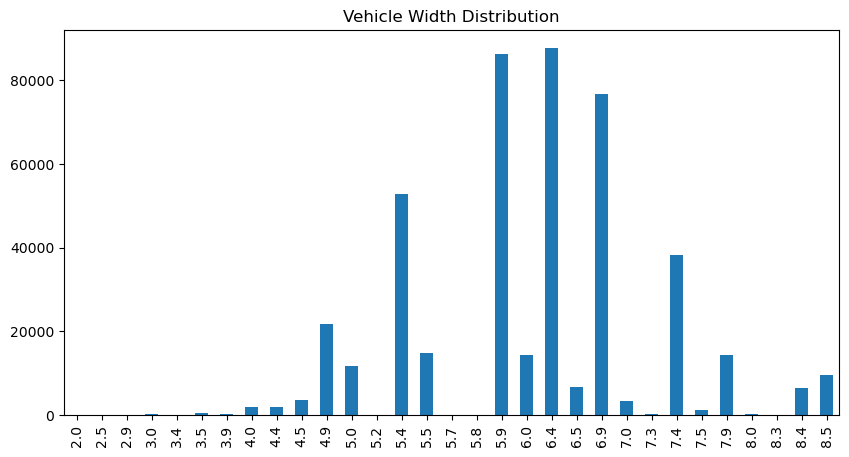

In [17]:
# Distribution of vehicle widths in the data
ax = df.v_Width.value_counts().sort_index().plot(kind='bar', figsize=(10,5), title='Vehicle Width Distribution')

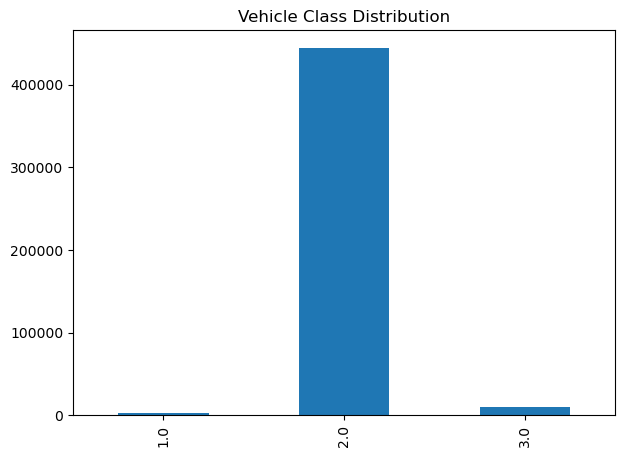

In [18]:
# Graph to show v_Class distribution
ax = df.v_Class.value_counts().sort_index().plot(kind='bar', figsize=(7,5), title='Vehicle Class Distribution')

In [19]:
# The number of vehicles that used each lane
df.Lane_ID.value_counts()

2.0    94821
1.0    93273
3.0    89603
4.0    88966
5.0    81591
6.0     5614
7.0     1409
8.0      569
Name: Lane_ID, dtype: int64

In [20]:
speed_columns = ['v_Vel', 'v_Acc']

<Figure size 640x480 with 0 Axes>

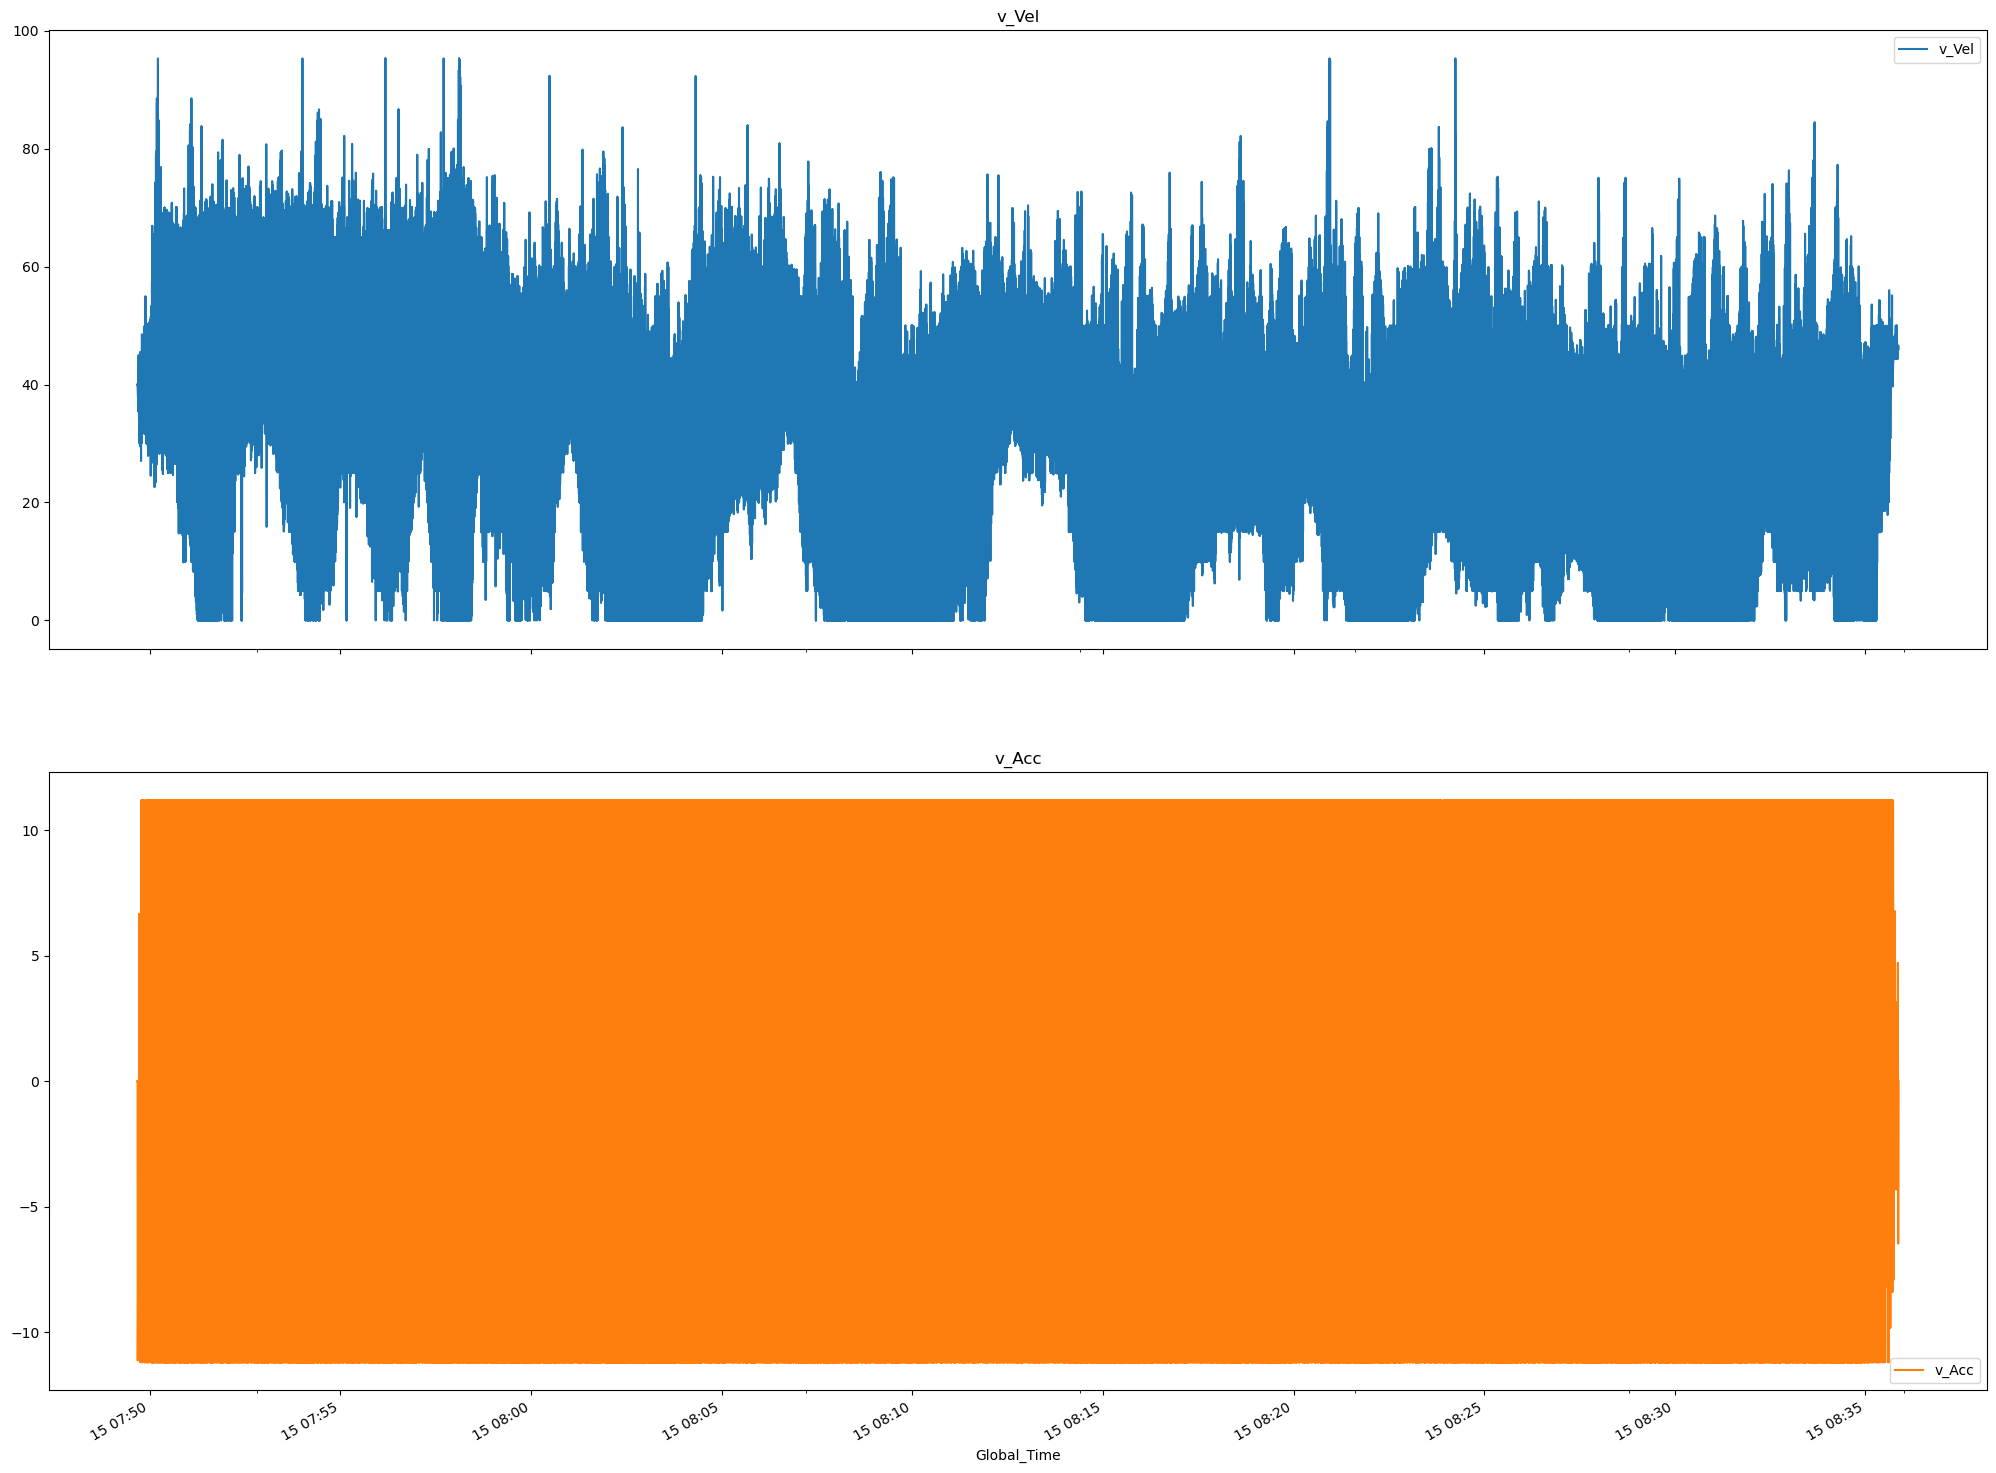

In [21]:
# Time series to show the behaviour of the vehicles velocity and acceleration over time
plt.figure()
ax = df.plot(x='Global_Time', y=speed_columns, kind='line', figsize=(25, 20), subplots=True,
                title=speed_columns)

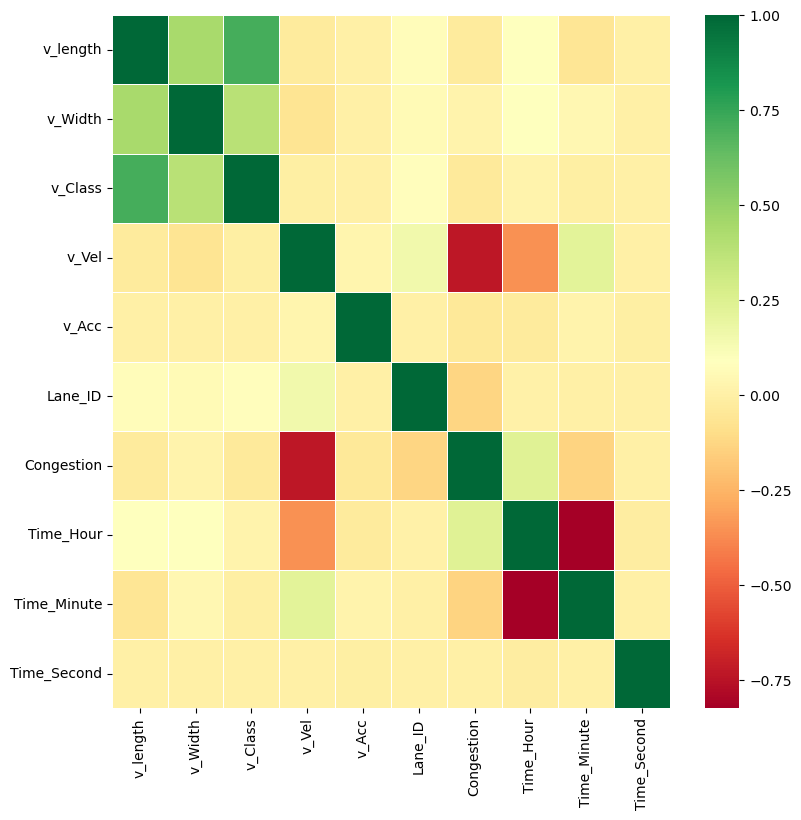

In [22]:
# Heatmap to show the correlation between the variables
corr = df.corr()
plt.figure(figsize=(9,9))
ax = sns.heatmap(corr, linewidth=0.5, cmap='RdYlGn')


In [23]:
df.Time.describe()

count       455846
unique        2772
top       08:31:24
freq           292
Name: Time, dtype: object

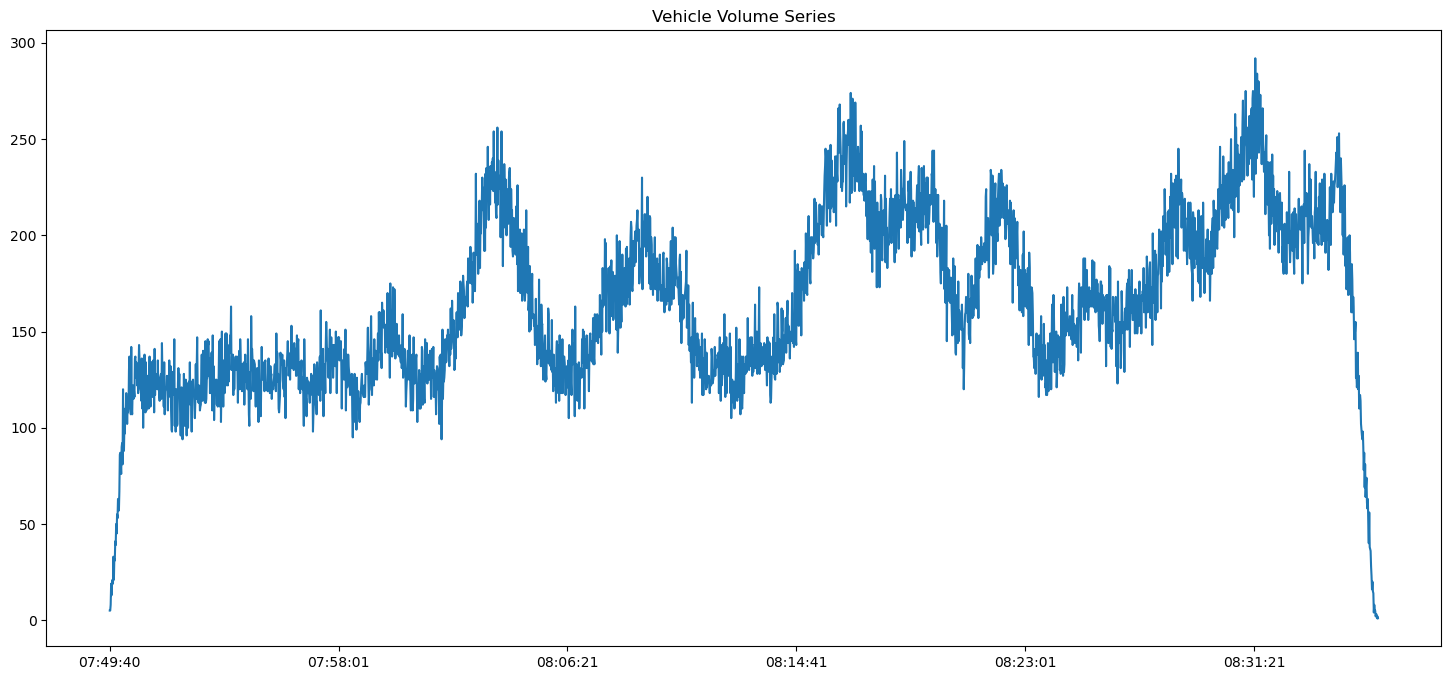

In [24]:
ax = df.Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')


In [25]:
ax.get_figure().savefig('Vehicle Volume.png')

Model Building

Preparing the data

In [26]:
# Dataframe to be used for model prediction
data = df.iloc[:, 1:11]

In [27]:
data.head()

,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Congestion,Time_Hour,Time_Minute,Time_Second
0,13.0,6.9,2.0,23.31,2.05,3.0,0,8,7,55
1,13.5,6.9,2.0,37.52,11.20,2.0,0,8,0,24
2,13.5,4.4,2.0,41.99,0.10,1.0,0,8,12,4
3,24.0,8.5,3.0,45.12,-0.55,5.0,0,8,34,32
4,15.0,5.9,2.0,24.54,-0.04,3.0,1,8,9,41


In [28]:
# Select feature columns and convert them to a numpy array
X = data.drop('Congestion', axis=1).values

In [29]:
X

array([[13. ,  6.9,  2. , ...,  8. ,  7. , 55. ],
       [13.5,  6.9,  2. , ...,  8. ,  0. , 24. ],
       [13.5,  4.4,  2. , ...,  8. , 12. ,  4. ],
       ...,
       [16.5,  6.4,  2. , ...,  8. , 16. , 31. ],
       [13.5,  5.9,  2. , ...,  8. , 15. , 56. ],
       [14.5,  7.4,  2. , ...,  8. , 33. , 22. ]])

In [30]:
# Select label columns and convert them to a numpy array
y = data.Congestion.values

In [31]:
y

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [32]:
# Split the data into the training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [33]:
# Feature scaling by standardizing the data for prediction
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

building the neural network

In [34]:
# Initializing the neural network
model = Sequential()

In [35]:
# Input layer with 9 nodes and a hidden layer with 5 nodes using the relu activation function
model.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 9))

In [36]:
# Output layer with 1 node using the sigmoid activation function
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [37]:
# Compile the neural network
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [38]:
 model.fit(X_train, y_train, batch_size = 10, epochs = 10)

Epoch 1/10
31910/31910 [==============================] - 25s 782us/step - loss: 0.2314 - accuracy: 0.8908
Epoch 2/10
31910/31910 [==============================] - 26s 822us/step - loss: 0.2165 - accuracy: 0.8981
Epoch 3/10
31910/31910 [==============================] - 28s 863us/step - loss: 0.2158 - accuracy: 0.8989
Epoch 4/10
31910/31910 [==============================] - 24s 764us/step - loss: 0.2153 - accuracy: 0.8988
Epoch 5/10
31910/31910 [==============================] - 24s 767us/step - loss: 0.2151 - accuracy: 0.8990
Epoch 6/10
31910/31910 [==============================] - 26s 814us/step - loss: 0.2149 - accuracy: 0.8991
Epoch 7/10
31910/31910 [==============================] - 24s 752us/step - loss: 0.2146 - accuracy: 0.8995
Epoch 8/10
31910/31910 [==============================] - 24s 765us/step - loss: 0.2143 - accuracy: 0.8997
Epoch 9/10
31910/31910 [==============================] - 25s 783us/step - loss: 0.2143 - accuracy: 0.8994
Epoch 10/10
31910/31910 [============

In [39]:
model.save('models/raw_model.keras')

In [40]:

model = load_model('models/raw_model.keras', compile=False)

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 50        
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 56
Trainable params: 56
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Use the model for predictions and convert probabilities above 0.5 to 1
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5

4274/4274 [==============================] - 4s 836us/step


In [43]:
# Check the confusion matrix
print(confusion_matrix(y_test, y_pred))

[[70760 12422]
 [ 1021 52551]]


In [44]:
# Check the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.85      0.91     83182
           1       0.81      0.98      0.89     53572

    accuracy                           0.90    136754
   macro avg       0.90      0.92      0.90    136754
weighted avg       0.92      0.90      0.90    136754



In [46]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)

F1 score: 0.8866000253068456


In [49]:
from sklearn.metrics import accuracy_score
print(f"accuracy: {accuracy_score(y_test, y_pred)}")

accuracy: 0.9016994018456499


In [50]:
# Check auc score
print(roc_auc_score(y_test, y_pred))

0.915803171956824


Undersampling and evaluating the prediction

In [53]:
# Import libraries
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [54]:
undersampler = RandomUnderSampler(sampling_strategy='majority')


In [55]:
X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)

In [56]:
Counter(y_train)

Counter({0: 193865, 1: 125227})

In [57]:
Counter(y_undersampled)

Counter({0: 125227, 1: 125227})

In [58]:
# Initializing the neural network
model = Sequential()

In [59]:
# Input layer with 9 nodes and a hidden layer with 5 nodes using the relu activation function
model.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 9))

In [60]:
# Output layer with 1 node using the sigmoid activation function
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [61]:
# Compile the neural network
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [62]:
res = model.fit(X_undersampled, y_undersampled)


7827/7827 [==============================] - 6s 700us/step - loss: 0.2570 - accuracy: 0.8930


In [63]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5

4274/4274 [==============================] - 2s 502us/step


In [64]:
# Check the confusion matrix
print(confusion_matrix(y_test, y_pred))

[[70691 12491]
 [ 1281 52291]]


In [65]:
# Check the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91     83182
           1       0.81      0.98      0.88     53572

    accuracy                           0.90    136754
   macro avg       0.89      0.91      0.90    136754
weighted avg       0.91      0.90      0.90    136754



In [66]:
f1_score(y_test, y_pred)

0.8836372239214559

In [67]:
accuracy_score(y_test, y_pred)

0.8992936221243986

K-FOLD

In [68]:
kf = KFold(n_splits=5, random_state=None, shuffle=True)

In [69]:
index = 0
models = {}
accuracy = []
f_score = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = Sequential()
    model.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 9))
    model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    trained_model = model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred = y_pred > 0.5

    print('Accuracy: ', accuracy_score(y_test, y_pred), 'F1 Score: ', f1_score(y_test, y_pred))

    models[index] = trained_model
    accuracy.append(accuracy_score(y_test, y_pred))
    f_score.append(f1_score(y_test, y_pred))

    index += 1

2850/2850 [==============================] - 2s 626us/step
Accuracy:  0.8795546780739278 F1 Score:  0.8452181267178801
2850/2850 [==============================] - 1s 506us/step
Accuracy:  0.8857835448452873 F1 Score:  0.8582242977929664
2850/2850 [==============================] - 1s 505us/step
Accuracy:  0.8887560464631619 F1 Score:  0.8656581980024902
2850/2850 [==============================] - 2s 524us/step
Accuracy:  0.8866171615351709 F1 Score:  0.8606328619002036
2850/2850 [==============================] - 2s 541us/step
Accuracy:  0.8859041998925073 F1 Score:  0.856969996974947


In [70]:
print('Average Accuracy: ', np.mean(accuracy), 'Average F1 Score: ', np.mean(f_score))

Average Accuracy:  0.8853231261620109 Average F1 Score:  0.8573406962776975


In [73]:
import pandas as pd
import numpy as np

# Assuming y_test and y_pred are NumPy arrays
y_test_series = pd.Series(y_test)
y_pred_flattened = np.ravel(y_pred)  # Flatten the y_pred array
y_pred_series = pd.Series(y_pred_flattened)

final_result = pd.concat([y_test_series, y_pred_series], axis=1)
final_result.columns = ['True Label', 'Predicted Label']

print(final_result)


       True Label  Predicted Label
0               0             True
1               1             True
2               0            False
3               1             True
4               0            False
...           ...              ...
91164           0            False
91165           1             True
91166           0             True
91167           1             True
91168           1             True

[91169 rows x 2 columns]
